In [1]:
import os
import sqlite3
import pandas as pd
import numpy as np
import datetime
import re
from pymystem3 import Mystem
from nltk.corpus import stopwords
import nltk
import pickle
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt

conn = sqlite3.connect(r"../../diplom.db")
cur = conn.cursor()

In [7]:
df = pd.read_sql("SELECT * FROM GD_TEXTS0021 WHERE DEMOCRACY_COUNT > 0;", conn)

In [63]:
df["SOVEREIGN"] = df["CLEAN_TEXT"].apply(sovereign_democracy)

In [64]:
df = df[df.DDATE>="2005-01-01"]
df["DDATE"] = pd.to_datetime(df.DDATE)
# sov = sov.set_index("DDATE")

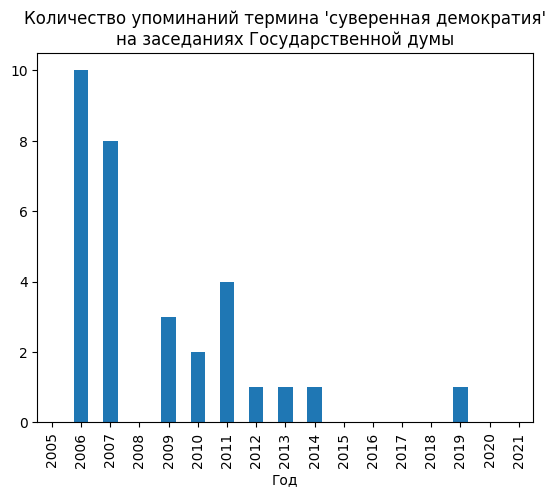

In [65]:
plot = df.groupby(df.DDATE.dt.year).SOVEREIGN.sum().plot(kind="bar")
plt.title("Количество упоминаний термина 'суверенная демократия'\nна заседаниях Государственной думы")
plt.xlabel("Год")
plt.savefig("Количество упоминаний термина 'суверенная демократия' на заседаниях Государственной думы.png")
plt.show()

In [66]:
sov = pd.read_csv("sovereignDemocracy.csv", header=1)

In [67]:
sov["Month"] = pd.to_datetime(sov["Month"])
sov = sov[(sov.Month>="2005")&(sov.Month<="2021")]

In [68]:
sov["Sovereign democracy: (Russia)"] = sov["Sovereign democracy: (Russia)"].replace("<1", 0).astype("int32")

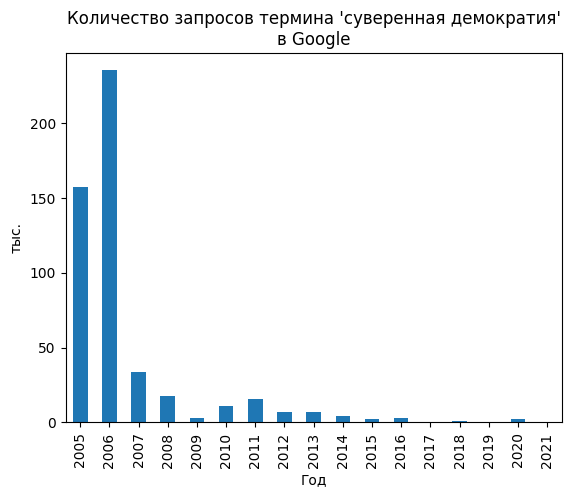

In [69]:
plot = sov.groupby(sov.Month.dt.year)["Sovereign democracy: (Russia)"].sum().plot(kind="bar")
plt.title("Количество запросов термина 'суверенная демократия'\nв Google")
plt.xlabel("Год")
plt.ylabel("тыс.")
plt.savefig("Количество запросов термина 'суверенная демократия' в Google.png")
plt.show()

In [2]:
corpus = [text[0].split() for text in cur.execute("""select CLEAN_TEXT from GOSDUMA;""").fetchall()]
graph = [i[0] for text in corpus for i in nltk.bigrams(text) if i[1] == "демократия"]
c = Counter(graph)
adjusting = pd.DataFrame(c.most_common()).rename(columns={0: "Слово", 1: "Количество"})
adjusting["Часть"] = [i[1] for i in nltk.pos_tag(adjusting["Слово"], lang="rus")]
adj = adjusting[adjusting["Часть"].isin(["A=m", "A-PRO=m"])].reset_index(drop=True)
s = adj["Количество"].sum()
adj["Процент"] = round(adj["Количество"]/s*100, 2)

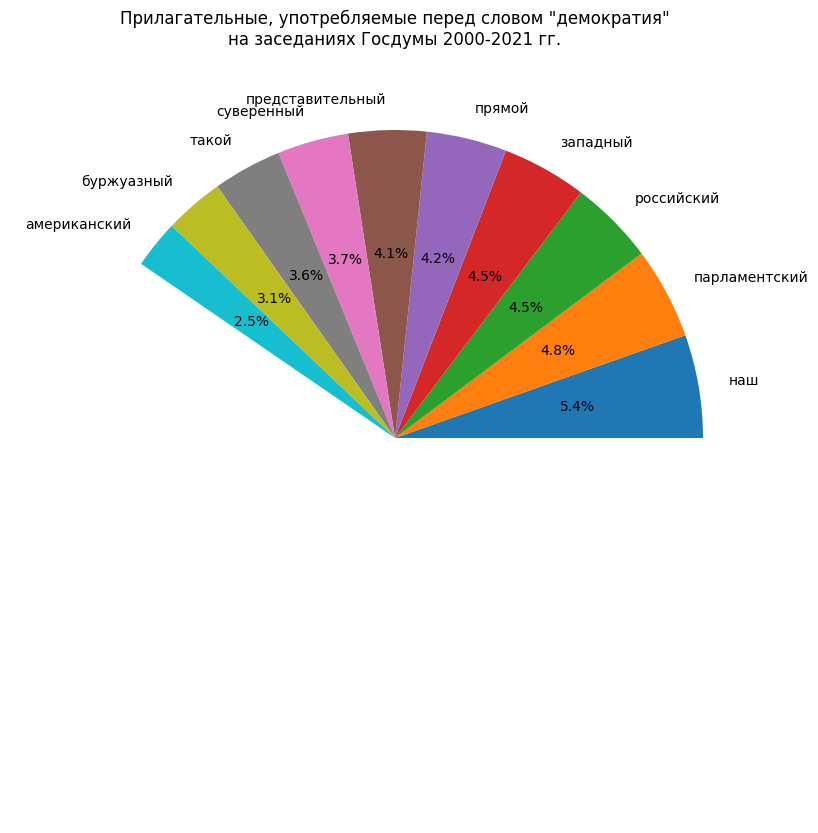

In [148]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10, forward=True)
temp2 = adj[["Слово", "Процент"]].head(10)
temp2.loc[10, "Слово"] = "Ост."
temp2.loc[10, "Процент"] = adj.loc[10:, "Процент"].sum()
wedge, text, procent = ax.pie(temp2["Процент"], labels=temp2["Слово"], autopct='%1.1f%%')
wedge[10].set_visible(False)
text[10].set_visible(False)
procent[10].set_visible(False)
ax.set_title('Прилагательные, употребляемые перед словом "демократия"\nна заседаниях Госдумы 2000-2021 гг.')
fig.savefig("gossduma_adj.png")

In [3]:
corpus = [text[0].split() for text in cur.execute("""select CLEAN_TEXT from GOSDUMA""").fetchall()]
model = Word2Vec(corpus, 
                 vector_size=1024,      # embedding vector size
                 min_count=2,
                 window=5).wv
model.save("gosduma.model")
model.most_similar('демократия')

[('диктатура', 0.667866051197052),
 ('демократический', 0.6293231248855591),
 ('коммунизм', 0.6222000122070312),
 ('буржуазный', 0.6189135313034058),
 ('социализм', 0.6163889765739441),
 ('демократ', 0.6119623184204102),
 ('либерализм', 0.609248697757721),
 ('капитализм', 0.6016980409622192),
 ('цивилизованный', 0.5987593531608582),
 ('завоевание', 0.5842779278755188)]